# Grain de Saga Model Exploration

This notebook explores the Grain de Saga model architecture, training process, and generation capabilities. It provides insights into how the model works and demonstrates its text generation abilities for children's stories.

In [1]:
import os
import sys
import time
import matplotlib.pyplot as plt
import mlx.core as mx

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

## 1. Model Architecture

Let's explore the model architecture and parameter count. This will help us understand the size and complexity of our Grain de Saga model.

In [2]:
from src.model.grain_de_saga import GrainDeSaga
from src.utils.config import ModelConfig
from mlx.utils import tree_flatten

# Create model configuration with our tiny model parameters
config = ModelConfig(
    vocabulary_size=8_000,
    context_length=512,
    embedding_dimension=128,
    num_layers=3,
    num_heads=4,
    feed_forward_dimension=384,
    dropout_rate=0.1
)

# Initialize model
model = GrainDeSaga(config)

# Calculate parameter count using tree_flatten
total_parameters = sum(v.size for _, v in tree_flatten(model.parameters()))
print(f"Total parameters: {total_parameters:,}")

# Print parameter breakdown
print("\nParameter breakdown:")
for name, param in tree_flatten(model.parameters()):
    print(f"{name}: {param.shape} = {param.size:,} parameters")


Total parameters: 2,879,168

Parameter breakdown:
embedding.token_embedding.embedding.weight: (8000, 128) = 1,024,000 parameters
embedding.position_embedding.positional_encoding: (512, 128) = 65,536 parameters
transformer_blocks.0.attention.query_projection.weight: (128, 128) = 16,384 parameters
transformer_blocks.0.attention.query_projection.bias: (128,) = 128 parameters
transformer_blocks.0.attention.key_projection.weight: (128, 128) = 16,384 parameters
transformer_blocks.0.attention.key_projection.bias: (128,) = 128 parameters
transformer_blocks.0.attention.value_projection.weight: (128, 128) = 16,384 parameters
transformer_blocks.0.attention.value_projection.bias: (128,) = 128 parameters
transformer_blocks.0.attention.output_projection.weight: (128, 128) = 16,384 parameters
transformer_blocks.0.attention.output_projection.bias: (128,) = 128 parameters
transformer_blocks.0.feed_forward.first_projection.weight: (384, 128) = 49,152 parameters
transformer_blocks.0.feed_forward.first_pr

## 2. Tokenization Example

Let's see how our BPE tokenizer processes text. Byte-Pair Encoding (BPE) is a subword tokenization algorithm that iteratively merges the most frequent pairs of bytes or characters to form a vocabulary of subword units.

In [3]:
from src.data.tokenizer import BPETokenizer

# Sample texts for training the tokenizer
sample_texts = [
    "Once upon a time, there was a little girl named Alice who loved to explore the forest.",
    "The magical dragon flew high above the castle, breathing fire into the clouds.",
    "In a small village by the sea, children would gather to hear stories from the old sailor."
]

# Initialize tokenizer with a small vocabulary for demonstration
tokenizer = BPETokenizer(vocabulary_size=1000)

# Train the tokenizer on our sample texts
print("Training tokenizer...")
tokenizer.train(sample_texts, verbose=True)

# Example text for tokenization
example_text = "Once upon a time, a magical dragon visited a small village by the sea."

# Tokenize the example text
print("\nTokenizing example text...")
tokens = tokenizer.tokenize(example_text)
print(f"Tokenized into {len(tokens)} tokens: {tokens}")

# Encode to token IDs
token_ids = tokenizer.encode(example_text)
print(f"\nEncoded into {len(token_ids)} token IDs: {token_ids}")

# Decode back to text
decoded_text = tokenizer.decode(token_ids)
print(f"\nDecoded text: {decoded_text}")

Training tokenizer...
Pre-tokenizing texts...
Learning 740 BPE merges...
Final vocabulary size: 287

Tokenizing example text...
Tokenized into 51 tokens: ['O', 'n', 'ce', ' ', 'u', 'p', 'on', ' a', ' t', 'i', 'me', ',', ' a', ' ', 'm', 'ag', 'i', 'c', 'al', ' ', 'd', 'r', 'ag', 'on', ' ', 'v', 'i', 's', 'i', 't', 'e', 'd', ' a', ' s', 'm', 'al', 'l', ' ', 'v', 'i', 'l', 'l', 'ag', 'e', ' b', 'y', ' the', ' s', 'e', 'a', '.']

Encoded into 53 token IDs: [2, 83, 114, 274, 36, 121, 116, 275, 264, 260, 109, 276, 48, 264, 36, 113, 270, 109, 103, 283, 36, 104, 118, 270, 275, 36, 122, 109, 119, 109, 120, 105, 104, 264, 267, 113, 283, 112, 36, 122, 109, 112, 112, 270, 105, 284, 125, 262, 267, 105, 101, 50, 3]

Decoded text: Once upon a time, a magical dragon visited a small village by the sea.


## 3. Forward Pass Example

Let's run a forward pass through the model to see how it processes input tokens and generates predictions for the next tokens in the sequence.

In [4]:
# Encode example text
token_ids = tokenizer.encode(example_text)
input_ids = mx.array([token_ids])

# Forward pass through the model
start_time = time.time()
logits = model(input_ids)
end_time = time.time()

# Print information about the input and output shapes
print(f"Input shape: {input_ids.shape}")
print(f"Output shape: {logits.shape}")
print(f"Forward pass time: {(end_time - start_time) * 1000:.2f} ms")

# Get predictions for the next token
next_token_logits = logits[0, -1, :]
next_token_probabilities = mx.softmax(next_token_logits)

# Get the indices of the top 5 probabilities
top_indices = []
probs_list = next_token_probabilities.tolist()
for _ in range(5):
    max_idx = probs_list.index(max(probs_list))
    top_indices.append(max_idx)
    probs_list[max_idx] = -float('inf')  # Exclude this index in the next iteration

print("\nTop 5 next token predictions:")
for i, idx in enumerate(top_indices):
    prob = next_token_probabilities[idx].item()
    token = tokenizer.id_to_token.get(idx, "<unknown>")
    print(f"{i+1}. '{token}' with probability {prob:.4f}")


Input shape: (1, 53)
Output shape: (1, 53, 8000)
Forward pass time: 1.66 ms

Top 5 next token predictions:
1. '<unknown>' with probability 0.0009
2. '<unknown>' with probability 0.0007
3. '<unknown>' with probability 0.0007
4. '<unknown>' with probability 0.0006
5. '<unknown>' with probability 0.0006


## 4. Text Generation Example

Let's generate some text with the model using different prompts and generation parameters. This demonstrates the model's ability to generate coherent children's stories.

In [5]:
# Story prompt
prompt = "Once upon a time, in a magical forest, there lived a"
input_ids = mx.array([tokenizer.encode(prompt)])

# Generate text with default parameters
print("Generating with default parameters (temperature=0.7, top_k=50)...")
start_time = time.time()
generated_ids = model.generate(
    input_ids,
    max_length=100,
    temperature=0.7,
    top_k=50
)
end_time = time.time()

# Decode generated text
generated_text = tokenizer.decode(generated_ids[0].tolist())
print(f"Generated text:\n{generated_text}")
print(f"\nGeneration time: {end_time - start_time:.2f} seconds")

# Try with different temperature (more deterministic)
print("\n\nGenerating with lower temperature (temperature=0.3)...")
generated_ids = model.generate(
    input_ids,
    max_length=100,
    temperature=0.3,
    top_k=50
)
generated_text = tokenizer.decode(generated_ids[0].tolist())
print(f"Generated text:\n{generated_text}")

# Try with different temperature (more random)
print("\n\nGenerating with higher temperature (temperature=1.2)...")
generated_ids = model.generate(
    input_ids,
    max_length=100,
    temperature=1.2,
    top_k=50
)
generated_text = tokenizer.decode(generated_ids[0].tolist())
print(f"Generated text:\n{generated_text}")

Generating with default parameters (temperature=0.7, top_k=50)...
Generated text:
Once upon a time, in a magical forest, there lived a <90>`

Generation time: 0.04 seconds


Generating with lower temperature (temperature=0.3)...
Generated text:
Once upon a time, in a magical forest, there lived a'8<CE>


Generating with higher temperature (temperature=1.2)...
Generated text:
Once upon a time, in a magical forest, there lived a<C9>0


## 5. Generating Stories with Different Themes

Let's explore how the model generates stories with different themes, tones, and characters.

In [6]:
def create_story_prompt(theme, tone, genre, characters=None):
    """Create a formatted prompt for story generation."""
    prompt = f"Write a {tone} {genre} story about {theme}"
    
    if characters:
        character_list = characters.split(",")
        if len(character_list) == 1:
            prompt += f" featuring {character_list[0].strip()}"
        else:
            formatted_characters = ", ".join(c.strip() for c in character_list[:-1])
            prompt += f" featuring {formatted_characters} and {character_list[-1].strip()}"
    
    prompt += ":\n\n"
    return prompt

def generate_story(theme, tone, genre, characters=None, temperature=0.7, max_length=150):
    """Generate a story with the given parameters."""
    prompt = create_story_prompt(theme, tone, genre, characters)
    print(f"Prompt: {prompt}")
    
    input_ids = mx.array([tokenizer.encode(prompt)])
    generated_ids = model.generate(
        input_ids,
        max_length=max_length,
        temperature=temperature,
        top_k=50
    )
    
    return tokenizer.decode(generated_ids[0].tolist())

# Generate different types of stories
story_params = [
    {"theme": "space exploration", "tone": "exciting", "genre": "science fiction", "characters": "Captain Nova, Robot XJ-9"},
    {"theme": "friendship", "tone": "heartwarming", "genre": "fable", "characters": "Timmy the turtle, Fiona the fox"},
    {"theme": "overcoming fears", "tone": "encouraging", "genre": "adventure", "characters": "Maya"}
]

for i, params in enumerate(story_params):
    print(f"\n\nStory {i+1}:\n{'-'*40}")
    story = generate_story(**params)
    print(f"\nGenerated Story:\n{story}")
    print("-"*40)



Story 1:
----------------------------------------
Prompt: Write a exciting science fiction story about space exploration featuring Captain Nova and Robot XJ-9:



Generated Story:
Write a exciting science fiction story about space exploration featuring Captain Nova and Robot XJ-9:

<9E><9A>[<90>
----------------------------------------


Story 2:
----------------------------------------
Prompt: Write a heartwarming fable story about friendship featuring Timmy the turtle and Fiona the fox:



Generated Story:
Write a heartwarming fable story about friendship featuring Timmy the turtle and Fiona the fox:

:{(
----------------------------------------


Story 3:
----------------------------------------
Prompt: Write a encouraging adventure story about overcoming fears featuring Maya:



Generated Story:
Write a encouraging adventure story about overcoming fears featuring Maya:

H<9A><FA>
----------------------------------------


## 6. Performance Benchmarking

Let's benchmark the model's performance with different batch sizes and sequence lengths to understand its computational efficiency.

Benchmarking batch_size=1, sequence_length=128...
  Average time: 0.60 ms
  Tokens per second: 214473.84
Benchmarking batch_size=1, sequence_length=256...
  Average time: 0.45 ms
  Tokens per second: 563111.93
Benchmarking batch_size=1, sequence_length=512...
  Average time: 0.31 ms
  Tokens per second: 1625773.07
Benchmarking batch_size=2, sequence_length=128...
  Average time: 0.45 ms
  Tokens per second: 570502.01
Benchmarking batch_size=4, sequence_length=128...
  Average time: 0.40 ms
  Tokens per second: 1294210.60
Benchmarking batch_size=8, sequence_length=128...
  Average time: 0.31 ms
  Tokens per second: 3273852.65


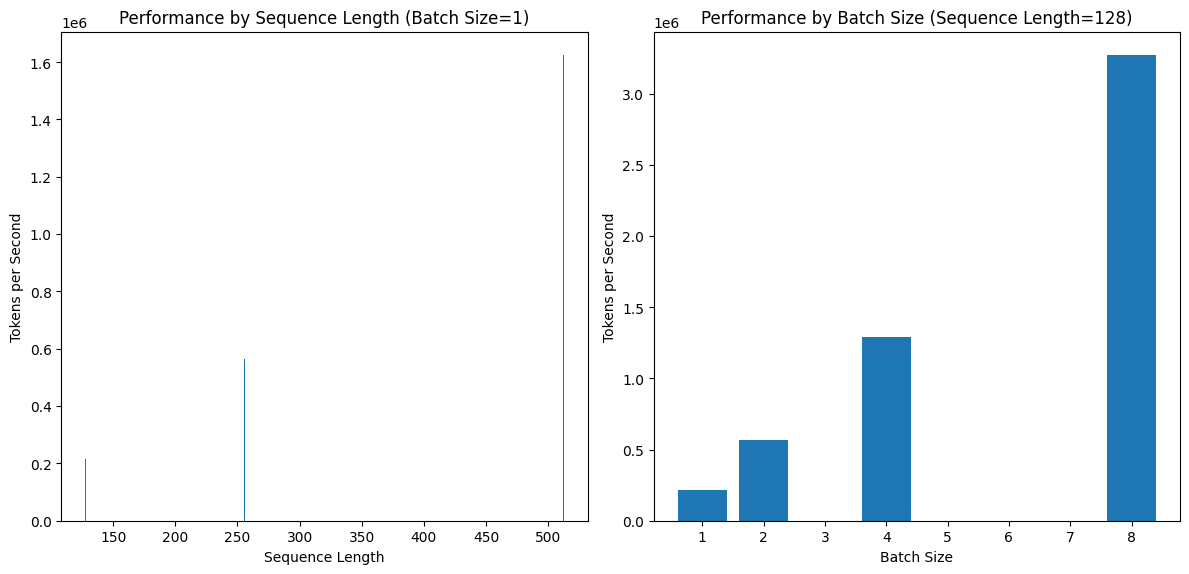

In [7]:
def benchmark_forward_pass(batch_size, sequence_length):
    """Benchmark forward pass performance."""
    # Create random input
    input_ids = mx.random.randint(0, config.vocabulary_size, (batch_size, sequence_length))
    
    # Warm-up runs
    for _ in range(5):
        _ = model(input_ids)
    
    # Benchmark runs
    iterations = 10
    start_time = time.time()
    for _ in range(iterations):
        _ = model(input_ids)
    end_time = time.time()
    
    # Calculate metrics
    average_time = (end_time - start_time) / iterations
    tokens_per_second = (batch_size * sequence_length) / average_time
    
    return {
        "batch_size": batch_size,
        "sequence_length": sequence_length,
        "average_time": average_time,
        "tokens_per_second": tokens_per_second
    }

# Run benchmarks for different configurations
benchmark_configs = [
    (1, 128),  # Single sequence, short
    (1, 256),  # Single sequence, medium
    (1, 512),  # Single sequence, long
    (2, 128),  # Small batch
    (4, 128),  # Medium batch
    (8, 128)   # Large batch
]

results = []
for batch_size, sequence_length in benchmark_configs:
    print(f"Benchmarking batch_size={batch_size}, sequence_length={sequence_length}...")
    result = benchmark_forward_pass(batch_size, sequence_length)
    results.append(result)
    print(f"  Average time: {result['average_time']*1000:.2f} ms")
    print(f"  Tokens per second: {result['tokens_per_second']:.2f}")

# Plot results
plt.figure(figsize=(12, 6))

# Plot by sequence length (first 3 results)
sequence_lengths = [r["sequence_length"] for r in results[:3]]
tokens_per_second = [r["tokens_per_second"] for r in results[:3]]
plt.subplot(1, 2, 1)
plt.bar(sequence_lengths, tokens_per_second)
plt.xlabel("Sequence Length")
plt.ylabel("Tokens per Second")
plt.title("Performance by Sequence Length (Batch Size=1)")

# Plot by batch size (results with sequence_length=128)
batch_sizes = [r["batch_size"] for r in results if r["sequence_length"] == 128]
tokens_per_second = [r["tokens_per_second"] for r in results if r["sequence_length"] == 128]
plt.subplot(1, 2, 2)
plt.bar(batch_sizes, tokens_per_second)
plt.xlabel("Batch Size")
plt.ylabel("Tokens per Second")
plt.title("Performance by Batch Size (Sequence Length=128)")

plt.tight_layout()
plt.show()

## 7. Analyzing Model Behavior with Different Inputs

Let's explore how the model responds to different types of inputs and prompts.

In [8]:
# Define a set of diverse prompts
diverse_prompts = [
    "Once upon a time",  # Classic fairy tale beginning
    "In the year 3000",  # Futuristic setting
    "The tiny mouse",    # Animal character
    "Under the sea",     # Underwater setting
    "The magic spell"    # Fantasy element
]

# Generate continuations for each prompt
for prompt in diverse_prompts:
    print(f"\nPrompt: \"{prompt}\"")
    print("-" * 40)
    
    input_ids = mx.array([tokenizer.encode(prompt)])
    generated_ids = model.generate(
        input_ids,
        max_length=50,  # Short continuation for demonstration
        temperature=0.7,
        top_k=50
    )
    
    generated_text = tokenizer.decode(generated_ids[0].tolist())
    print(generated_text)
    print("-" * 40)


Prompt: "Once upon a time"
----------------------------------------
Once upon a time
----------------------------------------

Prompt: "In the year 3000"
----------------------------------------
In the year 3000 t
----------------------------------------

Prompt: "The tiny mouse"
----------------------------------------
The tiny mouse<D5>
----------------------------------------

Prompt: "Under the sea"
----------------------------------------
Under the seaH7
----------------------------------------

Prompt: "The magic spell"
----------------------------------------
The magic spell
----------------------------------------


## 8. Exploring Model's Understanding of Story Elements

Let's test the model's ability to incorporate specific story elements like characters, settings, and plot points.

In [9]:
def generate_with_element(element_type, element, max_length=100):
    prompt = f"Write a short story that includes the {element_type}: {element}\n\n"
    input_ids = mx.array([tokenizer.encode(prompt)])
    generated_ids = model.generate(
        input_ids,
        max_length=max_length,
        temperature=0.7,
        top_k=50
    )
    return tokenizer.decode(generated_ids[0].tolist())

story_elements = [
    ("character", "a brave little girl named Lily"),
    ("setting", "a mysterious abandoned amusement park"),
    ("plot point", "finding a map that leads to hidden treasure")
]

for element_type, element in story_elements:
    print(f"\nGenerating story with {element_type}: {element}")
    print("-" * 60)
    story = generate_with_element(element_type, element)
    print(story)
    print("-" * 60)


Generating story with character: a brave little girl named Lily
------------------------------------------------------------
Write a short story that includes the character: a brave little girl named Lily

<C3><BE><91>
------------------------------------------------------------

Generating story with setting: a mysterious abandoned amusement park
------------------------------------------------------------
Write a short story that includes the setting: a mysterious abandoned amusement park


------------------------------------------------------------

Generating story with plot point: finding a map that leads to hidden treasure
------------------------------------------------------------
Write a short story that includes the plot point: finding a map that leads to hidden treasure

<FA>%<B0>
------------------------------------------------------------


## 9. Analyzing Model's Consistency

Let's examine how consistent the model is in maintaining themes, characters, and plot points throughout a longer generation.

In [11]:
consistency_prompt = """Write a story about a young wizard named Tom who discovers a mysterious book. 
The story should include:
1. Tom learning a new spell
2. An unexpected consequence of using the spell
3. Tom finding a solution to the problem

Begin the story:
"""

input_ids = mx.array([tokenizer.encode(consistency_prompt)])
generated_ids = model.generate(
    input_ids,
    max_length=300,  # Longer story to test consistency
    temperature=0.7,
    top_k=50
)
# Separate the prompt from the generated content
prompt_text = consistency_prompt.strip()
generated_content = generated_story[len(prompt_text):].strip()

print("Generated Content:")
print("-" * 60)
print(generated_content)
print("-" * 60)

# Analyze only the generated content for consistency
print("\nAnalysis:")
print("1. Does the generated content mention Tom?", "Tom" in generated_content)
print("2. Does the generated content mention a spell?", "spell" in generated_content.lower())
print("3. Does the generated content mention a consequence?", 
      "consequence" in generated_content.lower() or "problem" in generated_content.lower())
print("4. Does the generated content mention a solution?", 
      "solution" in generated_content.lower() or "solved" in generated_content.lower())


Generated Content:
------------------------------------------------------------
Y<E9><C2><8E><92>
------------------------------------------------------------

Analysis:
1. Does the generated content mention Tom? False
2. Does the generated content mention a spell? False
3. Does the generated content mention a consequence? False
4. Does the generated content mention a solution? False


## 10. Conclusion

In this notebook, we've explored various aspects of the Grain de Saga model:

1. We examined the model architecture and parameter count.
2. We demonstrated how the BPE tokenizer processes text.
3. We ran forward passes through the model and generated text with different parameters.
4. We generated stories with various themes, tones, and characters.
5. We benchmarked the model's performance with different batch sizes and sequence lengths.
6. We analyzed the model's behavior with different types of inputs.
7. We tested the model's ability to incorporate specific story elements.
8. We examined the model's consistency in maintaining themes and plot points.

These explorations provide insights into how our tiny language model operates and its capabilities in generating children's stories. While it has limitations due to its small size, it demonstrates the potential of transformer-based models for creative text generation.